# This fig is outdated, see align-all-disease
# Belayer Alignment of UC

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import statsmodels.stats.api as sms
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.collections import PatchCollection
from matplotlib.colors import to_rgba
from matplotlib.patches import Circle
%matplotlib inline

sys.path.append('/mnt/data1/spatial/tissue-alignment/traversal')
from io_utils import read_image, read_spatial_data
from plot import draw_clusters

In [2]:
uc_path = '/mnt/data1/spatial/data/colon/UC/B'
im = read_image(uc_path, False)
pos_df, spot_radius = read_spatial_data(uc_path, False)

In [3]:
boundary_idx_file='colon-UC-B-boundaries.npy'
bounds = np.load(boundary_idx_file, allow_pickle=True)
depths = pd.read_csv('belayer_uc_depths.csv')

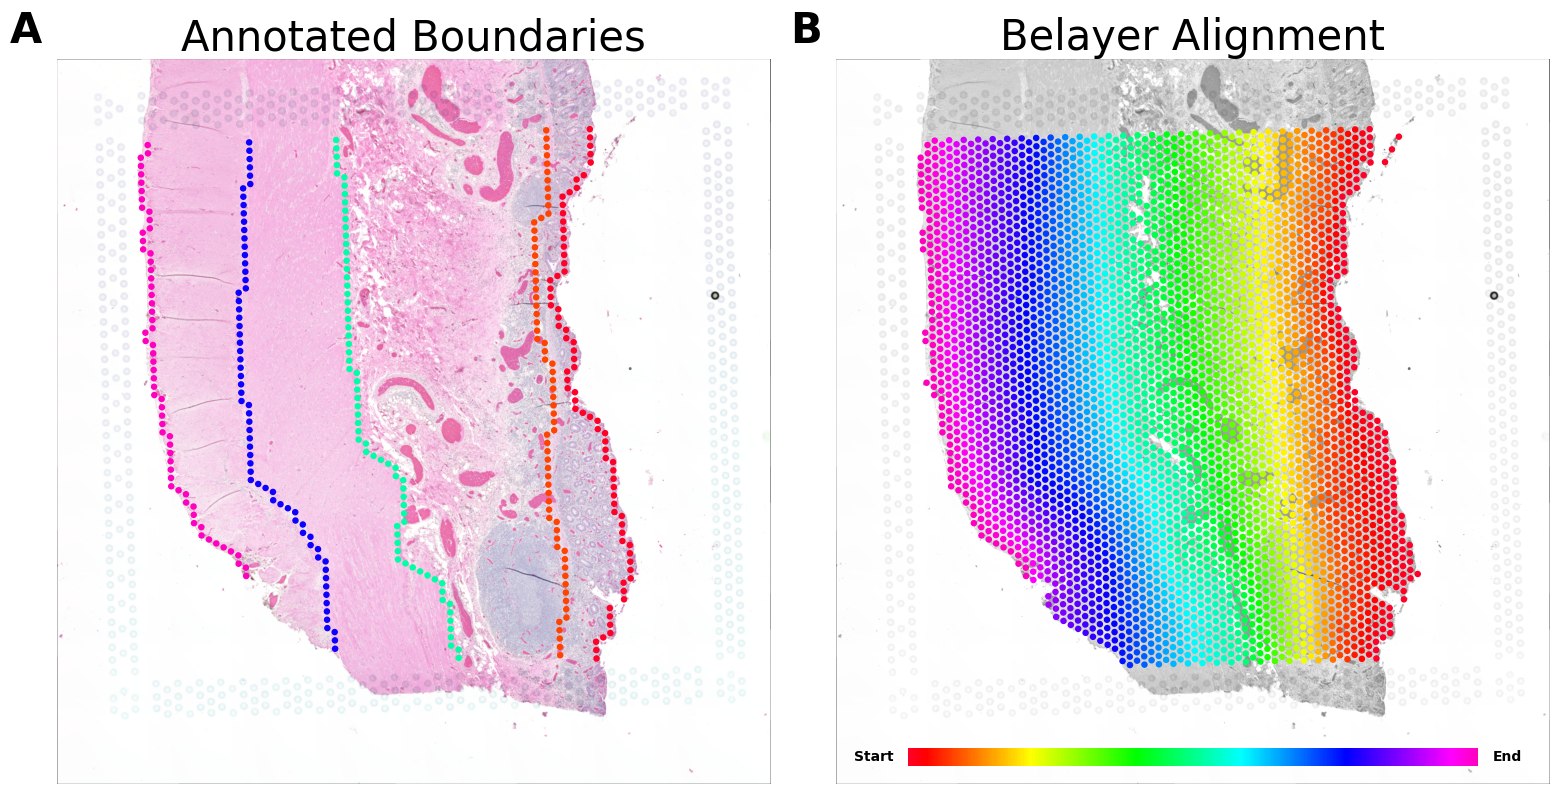

In [12]:
figsize = 8
fontsize = 15
nrows = 1
ncols = 2

plt.close()
fig, (axa, axb) = plt.subplots(nrows, ncols, figsize=(figsize*ncols, figsize*nrows))

axa.imshow(im)
axb.imshow(np.asarray(im.convert("L")), cmap='gray', vmin=0, vmax=255)
axa.set_axis_off()
axb.set_axis_off()

cm_name = 'gist_rainbow'
cmap = colormaps[cm_name]
cmap_interp = np.linspace(0, 1, depths['depth2'].max() + 1)

for b in bounds:
    bound_coords = pos_df.loc[b, ['x', 'y']].sort_values('y').to_numpy()
    avg_bound_depth = int(round(depths.loc[b, 'depth2'].mean()))
    color = cmap(cmap_interp[avg_bound_depth])
    for x, y in bound_coords:
        circ = Circle((x, y), spot_radius, color=color)
        axa.add_artist(circ)

circs = PatchCollection(
    [Circle((x, y), spot_radius) for x, y in pos_df[["x", "y"]].to_numpy()],
    picker=True,
)
facecolors = np.asarray([list(to_rgba("lightgray"))] * len(pos_df))
edgecolors = np.asarray([list(to_rgba("darkgray"))] * len(pos_df))
alphas = np.full(len(pos_df), 1)
circs.set_facecolor(facecolors)
circs.set_edgecolor(edgecolors)
circs.set_alpha(alphas)
axb.add_collection(circs)

axa.set_title('Annotated Boundaries', fontsize=fontsize*2)
axb.set_title('Belayer Alignment', fontsize=fontsize*2)

fig.tight_layout()
fig.subplots_adjust(top=0.925, left=0.025)

dummy_path_idxs = [-1] * (depths['depth2'].max() + 1)
draw_clusters(
    fig=fig,
    ax=axb,
    path_idxs=dummy_path_idxs,
    clusters=depths['depth2'],
    circs=circs,
    facecolors=facecolors,
    edgecolors=edgecolors,
    cm_name=cm_name,
)

axa_bbox = axa.get_position()
axb_bbox = axb.get_position()

def _panel_label_coords(bbox, xoffset=0.02, yoffset=0.01):
    x = bbox.xmin - bbox.width * xoffset
    y = bbox.ymax + bbox.height * yoffset
    return x, y

fig.text(*_panel_label_coords(axa_bbox), 'A', ha='right', va='bottom', fontsize=fontsize*2, weight='bold')
fig.text(*_panel_label_coords(axb_bbox), 'B', ha='right', va='bottom', fontsize=fontsize*2, weight='bold')

fig.savefig('figs/fig6.png')
fig.savefig('figs/fig6.pdf')